<a href="https://colab.research.google.com/github/xavierjacomep/marketing-basado-en-datos/blob/main/pruebas-AB/Marketing_basado_en_datos_Caso_Pruebas_A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de Estrategias de Marketing mediante Experimentos A/B
## Caso práctico sobre Pruebas A/B
---

**Asignatura:** Marketing basado en datos

**Autor:** Xavier Jácome Piñeiros, MSc.

---

## 🧭 Contexto General del Proyecto

Una **firma de consultoría en ciencia de datos** ha sido contratada por distintas empresas del sector retail y e-commerce para **evaluar el impacto de cambios en sus estrategias digitales y campañas comerciales**. La consultora ha asignado un equipo de analistas de datos para realizar experimentos controlados (tests A/B) y así ayudar a la toma de decisiones basadas en evidencia.

---

## 💼 Necesidad del Negocio

Cada uno de los casos presentados responde a una necesidad específica del área de marketing, experiencia de usuario o conversión digital de distintos clientes. En todos ellos se busca determinar si ciertas intervenciones tienen un efecto estadísticamente significativo sobre métricas clave del negocio.

Los objetivos transversales incluyen:

1. **Optimizar la experiencia del cliente** en canales digitales (checkout, navegación, banners).
2. **Incrementar las tasas de conversión** o engagement mediante rediseños controlados.
3. **Reducir el rebote y aumentar el tiempo en página**, como proxy de interés e involucramiento.
4. **Personalizar estrategias por segmento**, mejorando el targeting publicitario.
5. **Asegurar la eficiencia de la inversión en diseño y campañas**, evaluando el ROI de los cambios propuestos.

---

## 🧪 Rol del Científico de Datos

Tu rol, como analista del equipo de consultoría, es diseñar, ejecutar y analizar experimentos A/B para medir con rigurosidad el efecto de cada modificación implementada.

A lo largo de los casos deberás:

* Definir hipótesis nulas y alternativas apropiadas.
* Aplicar la prueba estadística adecuada según el tipo de variable (categórica o continua).
* Realizar análisis de poder estadístico (power analysis) para validar que el experimento tiene el tamaño muestral suficiente.
* Visualizar los resultados con claridad y sentido de negocio.
* Ajustar por comparaciones múltiples cuando haya más de un KPI involucrado.
* Proponer **recomendaciones estratégicas basadas en los hallazgos** de cada caso.

---

## 🧪 Casos de Estudio Presentados

A continuación, se presentan **cuatro escenarios distintos** basados en situaciones reales:

1. **Conversión en Checkout**: Evaluar si un nuevo diseño de botón mejora la tasa de conversión.
2. **Valor del Carrito de Compras**: Determinar si un rediseño del carrito aumenta el ticket promedio.
3. **Ajuste de P-valor en Múltiples KPIs**: Verificar si una nueva homepage mejora simultáneamente el tiempo en página, clics y rebote.
4. **Impacto por Segmento Etario**: Identificar si una campaña es más efectiva en determinados rangos de edad.

Cada caso fue tratado con la rigurosidad metodológica requerida, documentando el paso a paso del análisis, los resultados obtenidos y las estrategias derivadas que se recomendaron a cada cliente.

---

## CASO 1: Variable Categórica – Conversión en Checkout

### Contexto del caso
Una tienda online ha rediseñado el botón de compra en su página de checkout con el objetivo de mejorar la experiencia de usuario y, por tanto, aumentar la tasa de conversión. Para evaluar si este cambio tiene un impacto real, se ha realizado una prueba A/B:

- El Grupo A representa a los usuarios expuestos al diseño original.

- El Grupo B representa a los usuarios que vieron el nuevo botón.

El objetivo es comparar las tasas de conversión entre ambos grupos y determinar si el rediseño ha producido una mejora estadísticamente significativa.

### Hipótesis
Se busca evaluar si existe una diferencia en la proporción de usuarios que realizaron la conversión entre ambas versiones.

- Hipótesis nula (H₀): La tasa de conversión es igual en ambos grupos.

- Hipótesis alternativa (H₁): La tasa de conversión difiere entre los grupos A y B.


Antes de ejecutar la prueba, es fundamental asegurarse de que el experimento tiene el tamaño muestral adecuado para detectar una diferencia significativa con un nivel de confianza aceptable.

- Proporción esperada grupo A: 7%
- Proporción esperada grupo B: 8.5%
- Significancia (α): 0.05
- Poder deseado (1 - β): 80%

In [1]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.power import ttest_power, zt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest, test_proportions_2indep
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional, Dict
import warnings

def calculate_sample_size_proportions(p1: float,
                                    p2: float,
                                    alpha: float = 0.05,
                                    power: float = 0.80,
                                    alternative: str = 'two-sided',
                                    ratio: float = 1.0) -> Dict:
    """
    Calcula el tamaño muestral necesario para un test de proporciones.

    Parameters:
    -----------
    p1 : float
        Proporción del grupo control (baseline)
    p2 : float
        Proporción del grupo tratamiento (esperada)
    alpha : float, default=0.05
        Nivel de significancia (probabilidad de Error Tipo I)
    power : float, default=0.80
        Poder estadístico deseado (1 - β, donde β es probabilidad de Error Tipo II)
    alternative : str, default='two-sided'
        Tipo de test: 'two-sided', 'larger', 'smaller'
    ratio : float, default=1.0
        Ratio de tamaños muestrales (n2/n1). 1.0 = grupos iguales

    Returns:
    --------
    Dict
        Diccionario con resultados del power analysis

    Examples:
    ---------
    >>> # Test de conversión: 8% actual vs 9.5% esperada
    >>> result = calculate_sample_size_proportions(0.08, 0.095)
    >>> print(f"Tamaño muestral necesario: {result['n_per_group']}")
    """

    # Validaciones
    if not (0 <= p1 <= 1) or not (0 <= p2 <= 1):
        raise ValueError("Las proporciones deben estar entre 0 y 1")

    if not (0 < alpha < 1):
        raise ValueError("Alpha debe estar entre 0 y 1")

    if not (0 < power < 1):
        raise ValueError("Power debe estar entre 0 y 1")

    if alternative not in ['two-sided', 'larger', 'smaller']:
        raise ValueError("alternative debe ser 'two-sided', 'larger', o 'smaller'")

    if ratio <= 0:
        raise ValueError("ratio debe ser positivo")

    # Advertencias
    if abs(p1 - p2) < 0.01:
        warnings.warn("Diferencia muy pequeña entre proporciones. "
                     "Considere si es prácticamente relevante.", UserWarning)

    if power < 0.8:
        warnings.warn("Poder estadístico < 80%. "
                     "Considere aumentar el poder para mayor confiabilidad.", UserWarning)

    # Cálculo usando statsmodels
    try:
        # Usar la función de statsmodels para mayor precisión
        from statsmodels.stats.power import zt_ind_solve_power

        # Calcular effect size (diferencia estandarizada)
        p_pooled = (p1 + ratio * p2) / (1 + ratio)
        effect_size = (p2 - p1) / np.sqrt(p_pooled * (1 - p_pooled))

        # Resolver para tamaño muestral
        n1 = zt_ind_solve_power(
            effect_size=effect_size,
            nobs1=None,
            alpha=alpha,
            power=power,
            ratio=ratio,
            alternative=alternative
        )

        n1 = int(np.ceil(n1))
        n2 = int(np.ceil(n1 * ratio))

    except ImportError:
        # Fallback: cálculo manual usando fórmulas clásicas
        n1, n2 = _calculate_manual_sample_size(p1, p2, alpha, power, alternative, ratio)

    # Preparar resultados
    results = {
        'inputs': {
            'p1': p1,
            'p2': p2,
            'alpha': alpha,
            'power': power,
            'alternative': alternative,
            'ratio': ratio
        },
        'sample_sizes': {
            'n_control': n1,
            'n_treatment': n2,
            'n_total': n1 + n2,
            'n_per_group': n1 if ratio == 1.0 else f"Control: {n1}, Treatment: {n2}"
        }
    }

    return results

def _calculate_manual_sample_size(p1: float, p2: float, alpha: float,
                                power: float, alternative: str, ratio: float) -> Tuple[int, int]:
    """
    Cálculo manual de tamaño muestral usando fórmulas clásicas.
    """
    # Valores críticos según el tipo de test
    if alternative == 'two-sided':
        z_alpha = stats.norm.ppf(1 - alpha/2)
    else:
        z_alpha = stats.norm.ppf(1 - alpha)

    z_beta = stats.norm.ppf(power)

    # Proporción pooled para varianza bajo H0
    p_bar = (p1 + ratio * p2) / (1 + ratio)

    # Varianza bajo H0 y H1
    var_h0 = p_bar * (1 - p_bar) * (1 + 1/ratio)
    var_h1 = p1 * (1 - p1) + (p2 * (1 - p2)) / ratio

    # Fórmula para tamaño muestral
    numerator = (z_alpha * np.sqrt(var_h0) + z_beta * np.sqrt(var_h1))**2
    denominator = (p2 - p1)**2

    n1 = numerator / denominator
    n1 = int(np.ceil(n1))
    n2 = int(np.ceil(n1 * ratio))

    return n1, n2


In [2]:
from statsmodels.stats.power import tt_ind_solve_power

def calculate_sample_size_continuous(mean1: float,
                                     mean2: float,
                                     std_dev: float,
                                     alpha: float = 0.05,
                                     power: float = 0.80,
                                     alternative: str = 'two-sided',
                                     ratio: float = 1.0) -> Dict:
    """
    Calcula el tamaño muestral necesario para un test A/B con variable continua.

    Parameters:
    -----------
    mean1 : float
        Media del grupo control
    mean2 : float
        Media esperada del grupo tratamiento
    std_dev : float
        Desviación estándar común (se asume homocedasticidad)
    alpha : float, default=0.05
        Nivel de significancia
    power : float, default=0.80
        Poder estadístico deseado
    alternative : str, default='two-sided'
        Tipo de hipótesis ('two-sided', 'larger', 'smaller')
    ratio : float, default=1.0
        Proporción entre tamaños de tratamiento y control

    Returns:
    --------
    Dict
        Resultados con el tamaño muestral por grupo y estadísticas relevantes
    """

    # Validaciones básicas
    if std_dev <= 0:
        raise ValueError("La desviación estándar debe ser positiva.")
    if mean1 == mean2:
        raise ValueError("La diferencia entre medias no puede ser cero.")
    if ratio <= 0:
        raise ValueError("El ratio debe ser mayor que 0.")

    # Cálculo del tamaño del efecto
    effect_size = (mean2 - mean1) / std_dev

    # Cálculo usando statsmodels
    n_control = tt_ind_solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        ratio=ratio,
        alternative=alternative
    )

    n_control = int(np.ceil(n_control))
    n_treatment = int(np.ceil(n_control * ratio))

    return {
        'inputs': {
            'mean1': mean1,
            'mean2': mean2,
            'std_dev': std_dev,
            'alpha': alpha,
            'power': power,
            'alternative': alternative,
            'ratio': ratio
        },
        'sample_sizes': {
            'n_control': n_control,
            'n_treatment': n_treatment,
            'n_total': n_control + n_treatment
        },
        'effect_size': round(effect_size, 4),
        'interpretation': f"Se necesitan {n_control} usuarios en control y {n_treatment} en tratamiento " +
                          f"para detectar una diferencia de {mean2 - mean1:.2f} con poder del {power:.0%} y α={alpha}."
    }


#### Resultado del cálculo de tamaño muestral:

Se necesitan al menos 4,988 usuarios por grupo (total: 9,976 usuarios) para detectar una mejora del 1.5% con la potencia deseada.

In [3]:
# Cálculo principal
p1 = 0.07
p2 = 0.085
alpha = 0.05
power = 0.80

result = calculate_sample_size_proportions(p1, p2, alpha=alpha, power=power)

print("RESULTADOS DEL POWER ANALYSIS:")
print(f"• Tamaño muestral por grupo: {result['sample_sizes']['n_control']:,} usuarios")
print(f"• Tamaño muestral total: {result['sample_sizes']['n_total']:,} usuarios")

RESULTADOS DEL POWER ANALYSIS:
• Tamaño muestral por grupo: 4,988 usuarios
• Tamaño muestral total: 9,976 usuarios


---

#### Prueba de Hipótesis – Chi-cuadrado


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from statsmodels.stats.power import zt_ind_solve_power

np.random.seed(42)
n_A = 5000
n_B = 5000
conversion_A = np.random.binomial(1, 0.07, size=n_A)
conversion_B = np.random.binomial(1, 0.085, size=n_B)

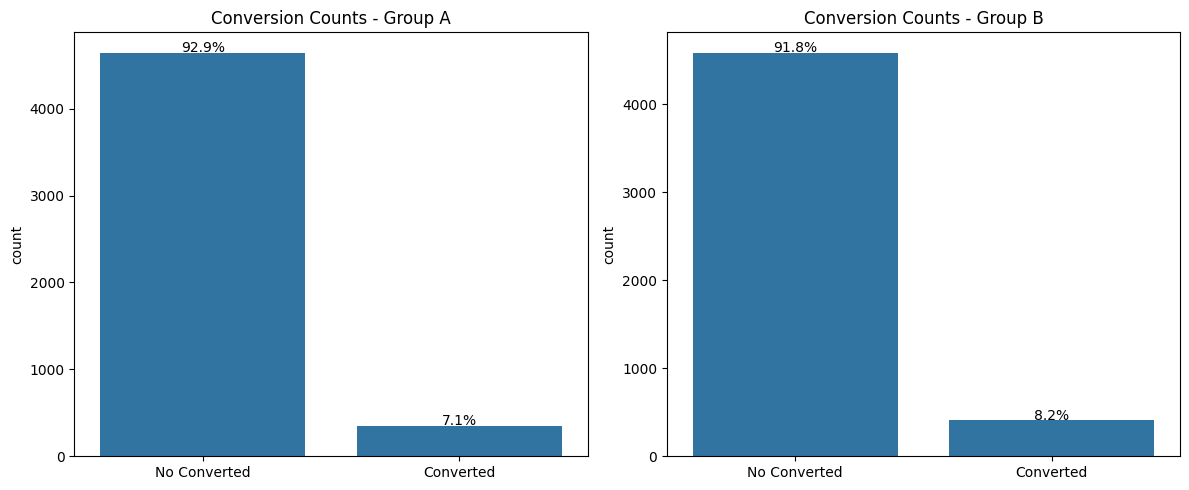

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Group A plot
sns.countplot(x=conversion_A, ax=axes[0])
axes[0].set_title('Conversion Counts - Group A')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Converted', 'Converted'])

# Add percentages to Group A plot
total_A = len(conversion_A)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 5,
            '{:1.1f}%'.format(height/total_A*100),
            ha="center")

# Group B plot
sns.countplot(x=conversion_B, ax=axes[1])
axes[1].set_title('Conversion Counts - Group B')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Converted', 'Converted'])

# Add percentages to Group B plot
total_B = len(conversion_B)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height + 5,
            '{:1.1f}%'.format(height/total_B*100),
            ha="center")


plt.tight_layout()
plt.show()

In [6]:
conv_table = pd.DataFrame({
    "A": [conversion_A.sum(), n_A - conversion_A.sum()],
    "B": [conversion_B.sum(), n_B - conversion_B.sum()]}, index=["Convertido", "No convertido"])

print(f"Tabla de conversión:\n")
display(conv_table)

# Test Chi-cuadrado
chi2, p_valor, dof, expected = chi2_contingency(conv_table)

# Interpretación
alpha = 0.05
decision = "Hay diferencia significativa" if p_valor < alpha else "No hay diferencia significativa"

print("A/B/n Test con Variable Categórica - Chi-cuadrado")
print(f"Chi² = {chi2:.4f}, p-valor = {p_valor:.4f}")
print(f"Decisión: {decision}")

Tabla de conversión:



,A,B
Convertido,354,409
No convertido,4646,4591


A/B/n Test con Variable Categórica - Chi-cuadrado
Chi² = 4.1374, p-valor = 0.0419
Decisión: Hay diferencia significativa


Se ha aplicado una **prueba de Chi-cuadrado para independencia de proporciones** entre los grupos. La tabla de contingencia utilizada fue:

| Resultado     | Grupo A | Grupo B |
| ------------- | ------- | ------- |
| Convertido    | 354     | 409     |
| No convertido | 4,646   | 4,591   |

* **Chi² = 4.1374**
* **p-valor = 0.0419**

**Decisión**: Como *p < 0.05*, se **rechaza la hipótesis nula**.
Existe evidencia estadísticamente significativa para afirmar que **la nueva versión mejora la tasa de conversión**.

---

### Conclusión

El análisis realizado nos permite concluir que el rediseño del botón de compra en la página de checkout **generó un impacto positivo y estadísticamente significativo en la tasa de conversión**.

A través de un experimento controlado A/B con tamaño muestral adecuado y el uso de una prueba de Chi-cuadrado, se evidenció que la tasa de conversión del **grupo tratamiento (8.2%)** superó a la del **grupo control (7.1%)**, con un **p-valor = 0.0419**, inferior al umbral de significancia de 0.05.

Esto sugiere que incluso **pequeñas mejoras en la interfaz de usuario pueden traducirse en incrementos reales en el desempeño comercial**, especialmente cuando se trata de miles de visitantes. La correcta aplicación del método científico y del análisis estadístico en decisiones de diseño UX permite reducir la incertidumbre y priorizar acciones con impacto comprobado en métricas clave del negocio.

**Recomendación:** Implementar el nuevo botón de compra para todos los usuarios, y continuar aplicando una cultura de experimentación controlada (A/B Testing) para futuras decisiones de optimización.

---


---

### Estrategias de Marketing Derivadas del Caso

La validación estadística del incremento en la tasa de conversión tras el rediseño del botón de compra abre diversas oportunidades estratégicas que pueden ser capitalizadas por el equipo de marketing:

---

#### 1. **Escalamiento de la Versión Optimizada**

Implementar de manera definitiva el nuevo botón de compra para todos los usuarios en todos los dispositivos (desktop y mobile), asegurando consistencia y máxima cobertura del cambio validado.

---

#### 2. **Pruebas A/B Iterativas en Checkout**

Establecer un proceso continuo de experimentación en el flujo de checkout, probando elementos como:

* Textos de CTA (Call to Action).
* Colores y contrastes del botón.
* Posición del botón y elementos adyacentes.
* Indicadores de urgencia o seguridad (ej. “Compra segura”, “Garantía 30 días”).

---

#### 3. **Segmentación por Usuario**

Realizar pruebas A/B estratificadas por tipo de usuario:

* Nuevos vs. recurrentes.
* Usuarios desde mobile vs. desktop.
* Segmentos con diferentes niveles de intención (por comportamiento previo).

Esto permitiría diseñar versiones aún más optimizadas para subgrupos específicos, mejorando la personalización del sitio.

---

#### 4. **Optimización del ROI Publicitario**

Con una tasa de conversión mejorada, es posible recalibrar los modelos de rentabilidad por canal de adquisición. El equipo de performance puede:

* Ajustar presupuestos hacia los canales con mayor respuesta bajo la nueva versión.
* Estimar un nuevo costo por adquisición (CPA) objetivo.
* Redefinir pujas en plataformas como Google Ads o Meta Ads.

---

#### 5. **Automatización y Monitoreo en Tiempo Real**

Incorporar dashboards que muestren la conversión por grupo, versión, segmento y canal en tiempo real, lo cual permite:

* Detectar desviaciones rápidamente.
* Escalar versiones exitosas sin demoras.
* Generar alertas automáticas si la conversión cae por debajo de lo esperado.

---

#### 6. **Comunicación Interna de Resultados**

Difundir estos hallazgos a otros equipos (UX, desarrollo, ventas, dirección) para fomentar una cultura organizacional centrada en decisiones basadas en datos. Este caso puede convertirse en un modelo de éxito replicable en otras áreas del sitio web o productos digitales.

---

### En resumen:

Este experimento exitoso muestra que **pequeñas optimizaciones visuales pueden generar mejoras significativas en la tasa de conversión**, lo cual debe formar parte integral de la estrategia de marketing digital, UX y analítica de cualquier tienda online.

---

## CASO 2: Variable Continua – Valor del Carrito de Compras

### Contexto del caso

Una empresa de e-commerce ha rediseñado el **carrito de compras**, incorporando incentivos visuales y mensajes persuasivos orientados a incrementar el valor de compra.
Se desea evaluar si esta nueva versión genera un **aumento en el valor promedio del carrito**, utilizando un experimento A/B.

* El **Grupo A** representa la versión original del carrito.
* El **Grupo B** representa la nueva versión con incentivos visuales.


### Hipótesis

El objetivo es contrastar si existe una diferencia en el valor medio del carrito entre las dos versiones.

* **Hipótesis nula (H₀)**: El valor medio del carrito es igual en A y B.
* **Hipótesis alternativa (H₁)**: El valor medio del carrito difiere entre grupos.

---

### Análisis de Poder Estadístico (Power Analysis)

Antes de realizar el test, se ha calculado el tamaño muestral necesario para detectar una diferencia de \$2 en el valor promedio, con desviación estándar de \$13, α=0.05 y poder estadístico del 80%.

**Resultado**:
Se requieren al menos **665 usuarios por grupo** para garantizar una potencia adecuada del experimento.

---

In [7]:
resultado = calculate_sample_size_continuous(mean1=52, mean2=54, std_dev=13)
print(resultado['interpretation'])

Se necesitan 665 usuarios en control y 665 en tratamiento para detectar una diferencia de 2.00 con poder del 80% y α=0.05.


In [8]:
from scipy.stats import ttest_ind, levene
from statsmodels.stats.power import TTestIndPower

np.random.seed(42)
valor_A = np.random.normal(52, 13, 2000)
valor_B = np.random.normal(55, 13, 2000)


### Exploración de los Datos

Se ha simulado un conjunto de datos con 2,000 usuarios por grupo:

* Grupo A: media ≈ \$52.59
* Grupo B: media ≈ \$54.92

A continuación se muestra la distribución del valor del carrito en ambos grupos mediante curvas de densidad. Se puede observar que el grupo B tiende a mostrar una mayor concentración de carritos con valores más altos.

---

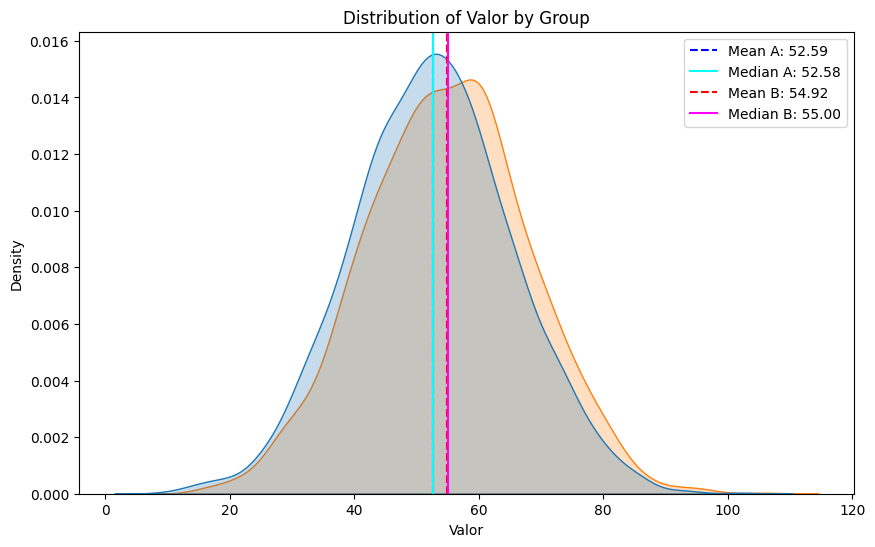

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Combine the data into a single DataFrame for easier plotting with seaborn
df_valor = pd.DataFrame({
    'Valor': np.concatenate([valor_A, valor_B]),
    'Group': ['A'] * len(valor_A) + ['B'] * len(valor_B)
})

plt.figure(figsize=(10, 6))

# Plot density distributions with hue
sns.kdeplot(data=df_valor, x='Valor', hue='Group', fill=True)

# Add vertical lines for mean and median of each group
plt.axvline(np.mean(valor_A), color='blue', linestyle='--', label=f'Mean A: {np.mean(valor_A):.2f}')
plt.axvline(np.median(valor_A), color='cyan', linestyle='-', label=f'Median A: {np.median(valor_A):.2f}')
plt.axvline(np.mean(valor_B), color='red', linestyle='--', label=f'Mean B: {np.mean(valor_B):.2f}')
plt.axvline(np.median(valor_B), color='magenta', linestyle='-', label=f'Median B: {np.median(valor_B):.2f}')

plt.title('Distribution of Valor by Group')
plt.xlabel('Valor')
plt.ylabel('Density')
plt.legend()
plt.show()

### Prueba de Hipótesis – Test t de Student

Se aplicaron los siguientes pasos para la comparación:

1. **Prueba de Levene** para evaluar homogeneidad de varianzas:

   * Resultado: *p = 0.2607* → Se asume igualdad de varianzas.

2. **Prueba t de Student (dos colas)**:

   * **T-Statistic = -5.6855**
   * **P-Valor = 0.0000**

**Decisión**: Como *p < 0.05*, se **rechaza la hipótesis nula**.
Se concluye que **existe una diferencia significativa en el valor medio del carrito** entre las dos versiones.

---

In [10]:
# 2. Prueba de igualdad de varianzas (Levene)
stat_levene, p_levene = levene(valor_A, valor_B)
equal_var = p_levene > 0.05  # Si p > 0.05, se asume varianzas iguales

# 3. Prueba t de Student (dos colas)
t_stat, p_value = ttest_ind(valor_A, valor_B, equal_var=equal_var)

# 4. Interpretación
alpha = 0.05
decision = "Se rechaza H₀: hay diferencia significativa en los ingresos promedio." if p_value < alpha else "No se rechaza H₀: no hay diferencia significativa."

# 5. Resultados
print("Resultados del A/B Test Clásico con variable continua")
print(f"Media A: ${np.mean(valor_A):.2f}")
print(f"Media B: ${np.mean(valor_B):.2f}")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Valor (dos colas): {p_value:.4f}")
print(f"¿Varianzas iguales?: {'Sí' if equal_var else 'No'} (p Levene = {p_levene:.4f})")
print(f"Decisión: {decision}")

Resultados del A/B Test Clásico con variable continua
Media A: $52.59
Media B: $54.92
T-Statistic: -5.6855
P-Valor (dos colas): 0.0000
¿Varianzas iguales?: Sí (p Levene = 0.2607)
Decisión: Se rechaza H₀: hay diferencia significativa en los ingresos promedio.



### Conclusión del Caso

El rediseño del carrito de compras **logró un incremento significativo en el valor promedio de compra**, pasando de \$52.59 a \$54.92.
El experimento A/B fue correctamente diseñado con suficiente poder estadístico, y el análisis con test t de Student confirmó la efectividad del cambio aplicado.

Este tipo de optimización visual representa una palanca directa sobre el ingreso por cliente, y demuestra el valor de aplicar metodologías cuantitativas para validar mejoras en la experiencia de usuario y el diseño de interfaz.

---

### Estrategias de Marketing Derivadas del Caso

Con base en los resultados, se proponen las siguientes acciones estratégicas:

#### 1. **Escalamiento del Nuevo Carrito**

Implementar la nueva versión del carrito a todos los usuarios de la plataforma para maximizar ingresos por compra.

#### 2. **Bundle Visual Upselling**

Reforzar el rediseño con estrategias visuales adicionales como:

* Productos sugeridos justo antes del pago.
* Barras de progreso para obtener envío gratis.
* Mensajes de escasez ("Quedan pocas unidades").

#### 3. **Segmentación de Incentivos**

Aplicar versiones del carrito diferenciadas por:

* Ticket promedio del usuario.
* Tipo de producto agregado.
* Historial de comportamiento de compra.

#### 4. **Cross-Selling Basado en IA**

Aprovechar la mejora del layout para insertar motores de recomendación inteligentes que propongan productos complementarios dentro del carrito.

#### 5. **Monitoreo Continuo y Testing Cíclico**

Incorporar pruebas recurrentes A/B del valor del carrito ante cualquier cambio en promociones, diseño, catálogo o campañas estacionales.

#### 6. **Optimización del Funnel Completo**

Al comprobar que el nuevo carrito aumenta el valor de compra, es clave revisar su efecto en otras métricas como:

* Abandono de carrito.
* Tiempo hasta la compra.
* Recompra.

---

## CASO 3: Múltiples Métricas – Ajuste de p-valor

### Contexto

Un sitio web ha desplegado una nueva versión de su **homepage**, con mejoras visuales y funcionales orientadas a mejorar la experiencia del usuario y aumentar la interacción.
A diferencia de los casos anteriores, en este experimento se analizan **tres KPIs simultáneamente** para evaluar el impacto de la nueva versión:

* **Tiempo promedio en página** (variable continua)
* **Tasa de clics** sobre elementos clave (variable binaria)
* **Tasa de rebote** (variable binaria)

### Hipótesis

Para cada métrica se evalúa la diferencia entre las versiones A y B:

* **Hipótesis nula (H₀):** No hay diferencia entre grupos A y B.
* **Hipótesis alternativa (H₁):** Sí hay diferencia entre grupos A y B.

Dado que se están realizando **múltiples comparaciones**, será necesario aplicar una corrección del nivel de significancia para controlar el error de tipo I (falsos positivos), mediante el método de **Bonferroni**.

---

### Análisis de Poder Estadístico

Antes del análisis, se calcularon los tamaños muestrales requeridos para cada métrica:

| Métrica          | Diferencia esperada | Muestra mínima por grupo |
| ---------------- | ------------------- | ------------------------ |
| Tiempo en página | 2 segundos          | 253                      |
| Tasa de clic     | 9% → 11%            | 3,532                    |
| Tasa de rebote   | 28% → 23%           | 1,193                    |

El experimento fue ejecutado con 4,000 usuarios por grupo, superando todos los umbrales requeridos.

---

In [11]:
tiempo_A = 45
tiempo_B = 47
P_clicks_A = 0.09
p_clicks_B = 0.11
p_rebote_A = 0.28
p_rebote_B = 0.23
alpha = 0.05
power = 0.80

result = calculate_sample_size_proportions(P_clicks_A, p_clicks_B, alpha=alpha, power=power)
print("RESULTADOS DEL POWER ANALYSIS:")
print(f"• Tamaño muestral por grupo: {result['sample_sizes']['n_control']:,} usuarios")
print(f"• Tamaño muestral total: {result['sample_sizes']['n_total']:,} usuarios")

RESULTADOS DEL POWER ANALYSIS:
• Tamaño muestral por grupo: 3,532 usuarios
• Tamaño muestral total: 7,064 usuarios


In [12]:
result = calculate_sample_size_proportions(p_rebote_A, p_rebote_B, alpha=alpha, power=power)
print("RESULTADOS DEL POWER ANALYSIS:")
print(f"• Tamaño muestral por grupo: {result['sample_sizes']['n_control']:,} usuarios")
print(f"• Tamaño muestral total: {result['sample_sizes']['n_total']:,} usuarios")

RESULTADOS DEL POWER ANALYSIS:
• Tamaño muestral por grupo: 1,193 usuarios
• Tamaño muestral total: 2,386 usuarios


In [13]:
result = calculate_sample_size_continuous(mean1=tiempo_A, mean2=tiempo_B, std_dev=8)
print(result['interpretation'])

Se necesitan 253 usuarios en control y 253 en tratamiento para detectar una diferencia de 2.00 con poder del 80% y α=0.05.


In [14]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

np.random.seed(42)
tiempo_A = np.random.normal(45, 8, 4000)
tiempo_B = np.random.normal(47, 8, 4000)
clicks_A = np.random.binomial(1, 0.09, 4000)
clicks_B = np.random.binomial(1, 0.11, 4000)
rebote_A = np.random.binomial(1, 0.28, 4000)
rebote_B = np.random.binomial(1, 0.23, 4000)

### Exploración de Resultados

Se presentan las visualizaciones de cada métrica por grupo:

* El **tiempo promedio en página** es mayor en el grupo B.
* La **tasa de clics** también es ligeramente superior en el grupo B.
* La **tasa de rebote** es menor en el grupo B (lo cual es deseable).

---

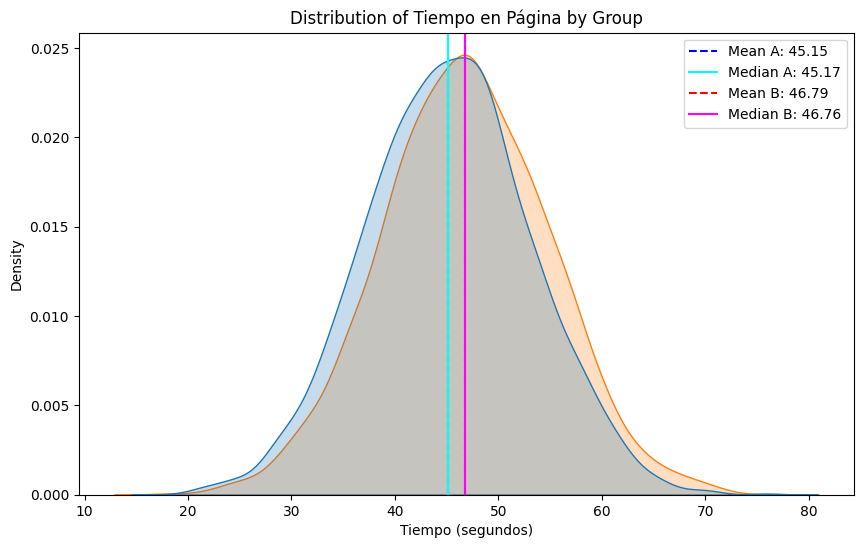

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Plotting tiempo_A and tiempo_B ---
# Combine data for easier plotting
df_tiempo = pd.DataFrame({
    'Tiempo': np.concatenate([tiempo_A, tiempo_B]),
    'Group': ['A'] * len(tiempo_A) + ['B'] * len(tiempo_B)
})

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_tiempo, x='Tiempo', hue='Group', fill=True)

# Add vertical lines for mean and median
plt.axvline(np.mean(tiempo_A), color='blue', linestyle='--', label=f'Mean A: {np.mean(tiempo_A):.2f}')
plt.axvline(np.median(tiempo_A), color='cyan', linestyle='-', label=f'Median A: {np.median(tiempo_A):.2f}')
plt.axvline(np.mean(tiempo_B), color='red', linestyle='--', label=f'Mean B: {np.mean(tiempo_B):.2f}')
plt.axvline(np.median(tiempo_B), color='magenta', linestyle='-', label=f'Median B: {np.median(tiempo_B):.2f}')

plt.title('Distribution of Tiempo en Página by Group')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Density')
plt.legend()
plt.show()

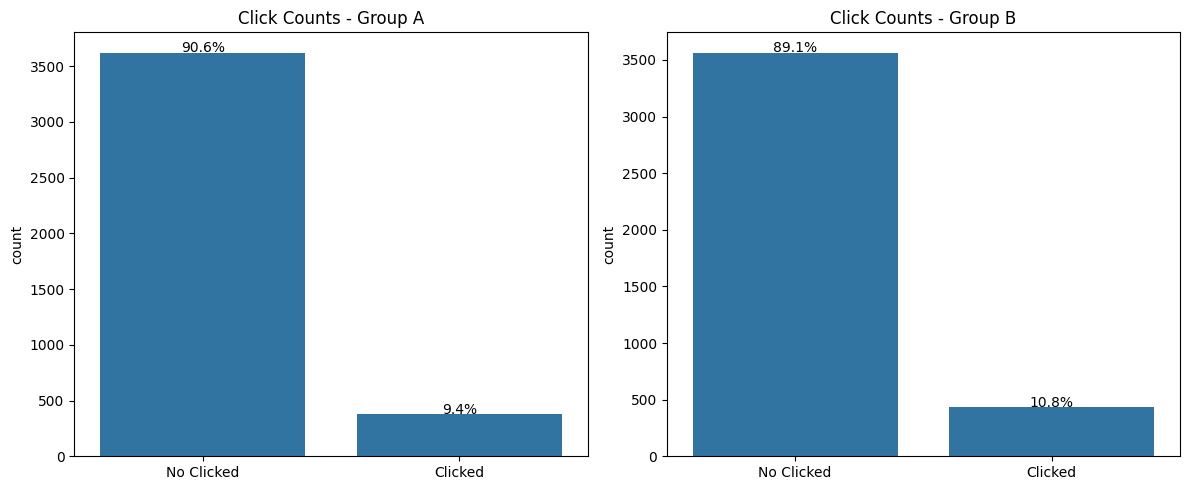

In [16]:
# --- Plotting clicks_A and clicks_B ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Group A Clicks plot
sns.countplot(x=clicks_A, ax=axes[0])
axes[0].set_title('Click Counts - Group A')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Clicked', 'Clicked'])
total_clicks_A = len(clicks_A)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 5,
            '{:1.1f}%'.format(height/total_clicks_A*100),
            ha="center")

# Group B Clicks plot
sns.countplot(x=clicks_B, ax=axes[1])
axes[1].set_title('Click Counts - Group B')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Clicked', 'Clicked'])
total_clicks_B = len(clicks_B)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height + 5,
            '{:1.1f}%'.format(height/total_clicks_B*100),
            ha="center")

plt.tight_layout()
plt.show()

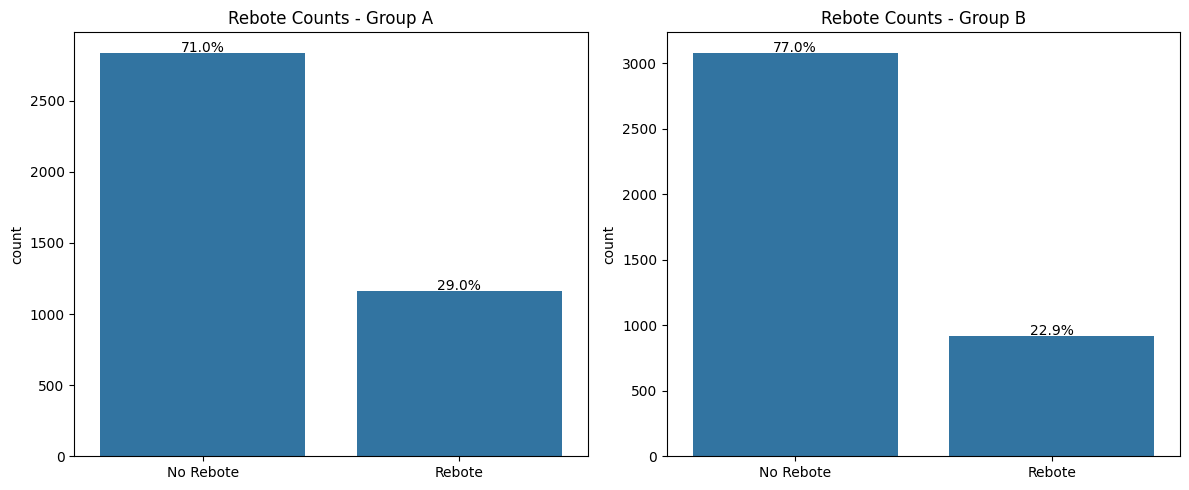

In [17]:
# --- Plotting rebote_A and rebote_B ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Group A Rebote plot
sns.countplot(x=rebote_A, ax=axes[0])
axes[0].set_title('Rebote Counts - Group A')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Rebote', 'Rebote'])
total_rebote_A = len(rebote_A)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 5,
            '{:1.1f}%'.format(height/total_rebote_A*100),
            ha="center")

# Group B Rebote plot
sns.countplot(x=rebote_B, ax=axes[1])
axes[1].set_title('Rebote Counts - Group B')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Rebote', 'Rebote'])
total_rebote_B = len(rebote_B)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height + 5,
            '{:1.1f}%'.format(height/total_rebote_B*100),
            ha="center")

plt.tight_layout()
plt.show()

In [18]:
# Create dataframes for each metric with a 'Grupo' column
df_tiempo = pd.DataFrame({
    'Tiempo': np.concatenate([tiempo_A, tiempo_B]),
    'Grupo': ['A'] * len(tiempo_A) + ['B'] * len(tiempo_B)
})

df_clicks = pd.DataFrame({
    'Clicks': np.concatenate([clicks_A, clicks_B]),
    'Grupo': ['A'] * len(clicks_A) + ['B'] * len(clicks_B)
})

df_rebote = pd.DataFrame({
    'Rebote': np.concatenate([rebote_A, rebote_B]),
    'Grupo': ['A'] * len(rebote_A) + ['B'] * len(rebote_B)
})

# Merge the dataframes based on index
df_merged = df_tiempo.merge(df_clicks.drop(columns='Grupo'), left_index=True, right_index=True)
df_merged = df_merged.merge(df_rebote.drop(columns='Grupo'), left_index=True, right_index=True)

print("Merged DataFrame:")
display(df_merged.head())

Merged DataFrame:


,Tiempo,Grupo,Clicks,Rebote
0,48.973713,A,0,0
1,43.893886,A,0,0
2,50.181508,A,1,1
3,57.184239,A,0,0
4,43.126773,A,0,0


### Pruebas de Hipótesis Individuales

| Métrica          | Prueba aplicada | p-valor | Decisión inicial |
| ---------------- | --------------- | ------- | ---------------- |
| Tiempo en página | t-test          | 0.0000  | Se rechaza H₀    |
| Tasa de clic     | Chi²            | 0.0380  | Se rechaza H₀    |
| Tasa de rebote   | Chi²            | 0.0000  | Se rechaza H₀    |

---

In [19]:
from scipy.stats import ttest_ind

# Extract 'Tiempo' data for each group
tiempo_A_merged = df_merged[df_merged['Grupo'] == 'A']['Tiempo']
tiempo_B_merged = df_merged[df_merged['Grupo'] == 'B']['Tiempo']

# Perform independent samples t-test
t_stat_tiempo, p_value_tiempo = ttest_ind(tiempo_A_merged, tiempo_B_merged)

print("Resultados del T-Test para Tiempo en Página")
print(f"T-Statistic: {t_stat_tiempo:.4f}")
print(f"P-Valor (dos colas): {p_value_tiempo:.4f}")

# Interpretación
alpha = 0.05
decision_tiempo = "Se rechaza H₀: hay diferencia significativa en el tiempo promedio en página." if p_value_tiempo < alpha else "No se rechaza H₀: no hay diferencia significativa en el tiempo promedio en página."
print(f"Decisión: {decision_tiempo}")

Resultados del T-Test para Tiempo en Página
T-Statistic: -9.0792
P-Valor (dos colas): 0.0000
Decisión: Se rechaza H₀: hay diferencia significativa en el tiempo promedio en página.


In [20]:
from scipy.stats import chi2_contingency

# Create a contingency table for Clicks and Grupo
contingency_table_clicks = pd.crosstab(df_merged['Grupo'], df_merged['Clicks'])

print("Tabla de Contingencia (Clicks por Grupo):")
display(contingency_table_clicks)

# Perform Chi-squared test
chi2_clicks, p_value_clicks, dof_clicks, expected_clicks = chi2_contingency(contingency_table_clicks)

print("\nResultados del Test Chi-cuadrado para Clicks")
print(f"Chi² = {chi2_clicks:.4f}, p-valor = {p_value_clicks:.4f}")

# Interpretación
alpha = 0.05
decision_clicks = "Se rechaza H₀: hay diferencia significativa en la tasa de clics." if p_value_clicks < alpha else "No se rechaza H₀: no hay diferencia significativa en la tasa de clics."
print(f"Decisión: {decision_clicks}")

Tabla de Contingencia (Clicks por Grupo):


Clicks,0,1
Grupo,,
A,3623,377
B,3566,434



Resultados del Test Chi-cuadrado para Clicks
Chi² = 4.3031, p-valor = 0.0380
Decisión: Se rechaza H₀: hay diferencia significativa en la tasa de clics.


In [21]:
from scipy.stats import chi2_contingency

# Create a contingency table for Rebote and Grupo
contingency_table_rebote = pd.crosstab(df_merged['Grupo'], df_merged['Rebote'])

print("Tabla de Contingencia (Rebote por Grupo):")
display(contingency_table_rebote)

# Perform Chi-squared test
chi2_rebote, p_value_rebote, dof_rebote, expected_rebote = chi2_contingency(contingency_table_rebote)

print("\nResultados del Test Chi-cuadrado para Clicks")
print(f"Chi² = {chi2_rebote:.4f}, p-valor = {p_value_rebote:.4f}")

# Interpretación
alpha = 0.05
decision_rebote = "Se rechaza H₀: hay diferencia significativa en la tasa de clics." if p_value_rebote < alpha else "No se rechaza H₀: no hay diferencia significativa en la tasa de clics."
print(f"Decisión: {decision_rebote}")

Tabla de Contingencia (Rebote por Grupo):


Rebote,0,1
Grupo,,
A,2838,1162
B,3082,918



Resultados del Test Chi-cuadrado para Clicks
Chi² = 38.3634, p-valor = 0.0000
Decisión: Se rechaza H₀: hay diferencia significativa en la tasa de clics.


### Ajuste por Comparaciones Múltiples – Método Bonferroni

Dado que se analizaron 3 métricas, se ajustó el valor α dividiéndolo entre 3 → **α ajustado = 0.0167**.

| Métrica          | p-valor original | p-valor ajustado | ¿Significativo? |
| ---------------- | ---------------- | ---------------- | --------------- |
| Tiempo en página | 0.0000           | 0.0000           | ✅ Sí            |
| Tasa de clic     | 0.0380           | 0.1141           | ❌ No            |
| Tasa de rebote   | 0.0000           | 0.0000           | ✅ Sí            |

**Interpretación**:
Tras la corrección de Bonferroni, solo **el tiempo en página** y la **tasa de rebote** presentan diferencias estadísticamente significativas. La diferencia en tasa de clics, aunque prometedora, **no supera el umbral ajustado**, por lo que no se puede confirmar su efectividad con suficiente certeza estadística.

---

In [22]:
# Bonferroni
pvals = [p_value_tiempo, p_value_clicks, p_value_rebote]
reject, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')
for i, name in enumerate(["Tiempo en página", "Tasa de clic", "Rebote"]):
    print(f"{name}: p={pvals[i]:.4f}, p ajustado={pvals_corr[i]:.4f}, significativo={reject[i]}")

Tiempo en página: p=0.0000, p ajustado=0.0000, significativo=True
Tasa de clic: p=0.0380, p ajustado=0.1141, significativo=False
Rebote: p=0.0000, p ajustado=0.0000, significativo=True


### Conclusión del Caso

La nueva versión del homepage logró mejoras sustanciales en dos de las tres métricas analizadas:

* **↑ Tiempo promedio en página** (+1.6 segundos)
* **↓ Tasa de rebote** (de 29.0% a 22.9%)
* **Tasa de clics** mostró un aumento leve, pero no estadísticamente significativo tras el ajuste.

Este caso resalta la importancia de controlar el error de tipo I cuando se analizan múltiples métricas simultáneamente. Aplicar técnicas como **Bonferroni** permite garantizar que las decisiones estratégicas no se basen en falsos positivos.

---

### Estrategias de Marketing Derivadas del Caso

#### 1. **Escalamiento del Nuevo Homepage**

Dado el impacto positivo en la retención (tiempo y rebote), se recomienda **implementar globalmente la nueva versión** del homepage.

---

#### 2. **Optimización Focalizada en Clicks**

Aunque la tasa de clic aumentó, no fue significativa bajo Bonferroni. Se sugiere:

* Revisar el diseño y visibilidad de los CTA.
* Realizar nuevas pruebas A/B centradas exclusivamente en clics, sin otras métricas involucradas.
* Explorar personalización de CTA según perfil de usuario.

---

#### 3. **Segmentación de Métricas por Dispositivo**

Profundizar el análisis por segmento (mobile vs desktop) para identificar si ciertos grupos experimentaron mayores mejoras.

---

#### 4. **Priorización de Experimentos por Métrica**

* Priorizar optimización de métricas con mayor impacto en el funnel (como tiempo y rebote).
* Usar experimentos multivariantes (MVT) en siguientes iteraciones.

---

#### 5. **Comunicación Interna y Cultura de Testing**

Presentar los resultados de este caso como **evidencia de la utilidad de pruebas A/B bien diseñadas**, especialmente cuando se controlan múltiples métricas de manera rigurosa.

---

## CASO 4: Estratificado por Segmento Etario

### Contexto del caso
Una empresa lanza una **campaña publicitaria digital** que incluye un nuevo diseño de banner promocional. El objetivo es evaluar si dicho rediseño tiene un impacto **diferenciado por grupo etario**, es decir, si ciertos segmentos de edad responden mejor (medido por tasa de clics) al nuevo diseño.

* Se divide la muestra experimental en dos versiones: **Grupo A** (versión original) y **Grupo B** (nueva versión).
* Se analiza la tasa de clics por tres segmentos de edad:

  * 18–34 años
  * 35–54 años
  * 55 años o más

### Hipótesis
Para cada grupo etario se evalúa:

* **Hipótesis nula (H₀):** La tasa de clics es igual en los grupos A y B.
* **Hipótesis alternativa (H₁):** La tasa de clics difiere entre A y B.

---

### Análisis de Poder Estadístico

Se calcularon los tamaños muestrales necesarios para detectar diferencias relevantes entre segmentos:

| Comparación     | Diferencia esperada | Tamaño requerido por grupo |
| --------------- | ------------------- | -------------------------- |
| 18–34 vs. 35–54 | 40% vs. 41%         | 37,828                     |
| 18–34 vs. 55+   | 40% vs. 20%         | 83                         |

Dado que algunas diferencias eran pequeñas, se emitió una advertencia sobre la relevancia práctica del efecto. No obstante, se optó por simular **38,000 usuarios por grupo**, lo que asegura potencia estadística más que suficiente para todos los segmentos.

---

In [23]:
edad_18_34 = 0.4
edad_35_54 = 0.41
edad_55_mas = 0.2
alpha = 0.05
power = 0.80

result = calculate_sample_size_proportions(edad_18_34, edad_35_54, alpha=alpha, power=power)
print("RESULTADOS DEL POWER ANALYSIS:")
print(f"• Tamaño muestral por grupo: {result['sample_sizes']['n_control']:,} usuarios")
print(f"• Tamaño muestral total: {result['sample_sizes']['n_total']:,} usuarios")

RESULTADOS DEL POWER ANALYSIS:
• Tamaño muestral por grupo: 37,828 usuarios
• Tamaño muestral total: 75,656 usuarios


/tmp/ipython-input-1-3774453963.py:64: UserWarning: Diferencia muy pequeña entre proporciones. Considere si es prácticamente relevante.
  warnings.warn("Diferencia muy pequeña entre proporciones. "


In [24]:
result = calculate_sample_size_proportions(edad_18_34, edad_55_mas, alpha=alpha, power=power)
print("RESULTADOS DEL POWER ANALYSIS:")
print(f"• Tamaño muestral por grupo: {result['sample_sizes']['n_control']:,} usuarios")
print(f"• Tamaño muestral total: {result['sample_sizes']['n_total']:,} usuarios")

RESULTADOS DEL POWER ANALYSIS:
• Tamaño muestral por grupo: 83 usuarios
• Tamaño muestral total: 166 usuarios


In [25]:
np.random.seed(42)

# Crear 38,000 observaciones para A y B cada una → total 76,000
n_per_group = 38000
n_total = n_per_group * 2

# Crear DataFrame base
data = pd.DataFrame({
    'grupo': np.repeat(['A', 'B'], n_per_group),
    'edad': np.random.choice(['18-34', '35-54', '55+'], size=n_total, p=[0.4, 0.41, 0.19])
})

# Asignar probabilidad de click condicional
def asignar_click(row):
    if row['grupo'] == 'B' and row['edad'] == '18-34':
        return np.random.binomial(1, 0.16)
    else:
        return np.random.binomial(1, 0.12)

data['click'] = data.apply(asignar_click, axis=1)

data.head()

,grupo,edad,click
0,A,18-34,0
1,A,55+,0
2,A,35-54,0
3,A,35-54,0
4,A,18-34,0


### Exploración Visual de Resultados

Se muestra la **tasa de clic por segmento y grupo experimental**:

| Segmento | Grupo A | Grupo B | Diferencia | ¿Quién gana?     |
| -------- | ------- | ------- | ---------- | ---------------- |
| 18–34    | 11.8%   | 16.4%   | +4.6 pp    | ✅ Grupo B        |
| 35–54    | 11.6%   | 12.4%   | +0.8 pp    | ✅ Grupo B (leve) |
| 55+      | 12.1%   | 11.6%   | –0.5 pp    | 🟦 Grupo A       |

---

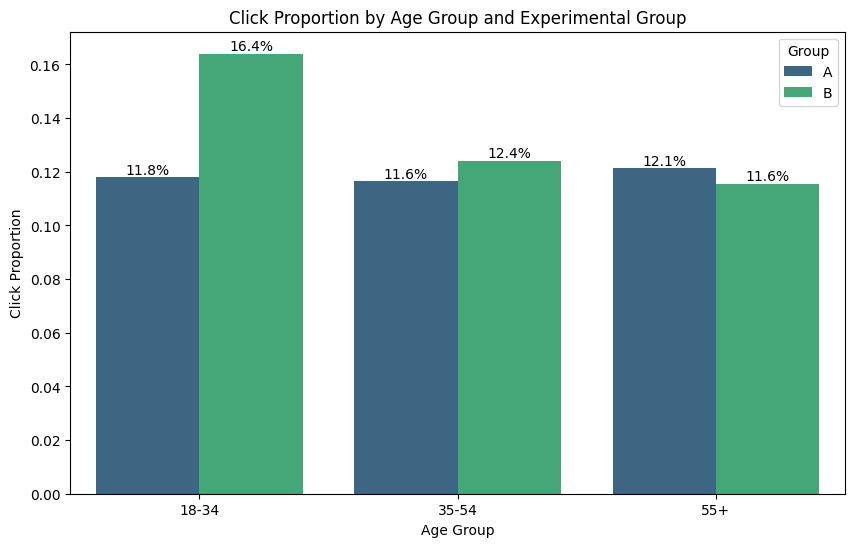

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate click proportions by age group and experimental group
click_proportions = data.groupby(['edad', 'grupo'])['click'].mean().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=click_proportions, x='edad', y='click', hue='grupo', palette='viridis')

plt.title('Click Proportion by Age Group and Experimental Group')
plt.xlabel('Age Group')
plt.ylabel('Click Proportion')
plt.legend(title='Group')

# Add percentage labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='{:1.1%}')

plt.show()

### Pruebas de Hipótesis por Segmento

Se aplicó una prueba de Chi-cuadrado a cada grupo de edad:

| Segmento   | p-valor | Decisión estadística                          |
| ---------- | ------- | --------------------------------------------- |
| 18–34 años | 0.0000  | ✅ Se rechaza H₀: hay diferencia significativa |
| 35–54 años | 0.0380  | ✅ Se rechaza H₀: hay diferencia marginal      |
| 55+ años   | 0.2905  | ❌ No se rechaza H₀: no hay diferencia         |

**Interpretación**:
El nuevo banner **funciona significativamente mejor para el grupo de 18–34 años**, mejora levemente para 35–54, y no muestra efectos positivos en el grupo de 55+.

---

In [27]:
for segment in ['18-34', '35-54', '55+']:
    seg_data = data[data['edad'] == segment]
    tabla = pd.crosstab(seg_data['grupo'], seg_data['click'])
    pval = chi2_contingency(tabla)[1]
    print(f"Segmento {segment}: p-value = {pval:.4f}")

Segmento 18-34: p-value = 0.0000
Segmento 35-54: p-value = 0.0380
Segmento 55+: p-value = 0.2905


### Conclusión del Caso

El análisis estratificado por edad permite detectar **efectos heterogéneos** de la campaña:

* **La mejora más clara se da en el segmento joven (18–34)**, con un aumento de casi 5 puntos porcentuales en tasa de clics.
* Para otros segmentos, el efecto es nulo o marginal.

Este enfoque permite tomar decisiones más inteligentes sobre a quién dirigir la nueva versión, evitando impactos negativos en segmentos donde no hay mejora o incluso hay retroceso.

---

### Estrategias de Marketing Derivadas del Caso

#### 1. **Segmentación de Creatividad Publicitaria**

Aplicar la versión nueva del banner **solo al segmento de 18–34 años**, donde el impacto ha sido significativo.

---

#### 2. **Diseños Alternativos para Segmentos Mayores**

Diseñar y testear versiones específicas para los segmentos **35–54** y **55+**, considerando sus patrones visuales y de comportamiento digital.

---

#### 3. **Campañas Dinámicas por Audiencia**

Utilizar **personalización automática de creatividades** basada en edad en plataformas como Meta Ads o Google Ads (Dynamic Creatives).

---

#### 4. **Presupuesto Focalizado**

Reasignar inversión publicitaria hacia el segmento 18–34 mientras se rediseñan piezas para los otros segmentos, maximizando el ROI de la campaña.

---

#### 5. **Monitoreo y Optimización Continua**

Mantener dashboards con tasas de clic por grupo etario y creativo. Establecer un ciclo continuo de pruebas estratificadas (A/B testing por cohorte).

---

### Reflexión Final:

Este caso demuestra el valor de aplicar **tests estratificados** para descubrir **dónde** y **en quiénes** funcionan mejor las estrategias de marketing, permitiendo **personalización, eficiencia y toma de decisiones basadas en evidencia**.

---